In [1]:
%pip install torchvision
%pip install matplotlib
%pip install scipy
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
import scipy
from torchvision import datasets, transforms
from torch import optim, nn, unsqueeze
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)), transforms.Grayscale(num_output_channels=1)])

# Download and load the training data
trainset0 = datasets.ImageFolder('mnist-varres/train', transform=transform)
testset = datasets.ImageFolder('mnist-varres/test', transform=transform)

# Also create a validation set 
trainset, valset = train_test_split(trainset0, test_size=10000, random_state=42)
#pytorch alternative for spliting into train and validation sets
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([16, 1, 64, 64])
torch.Size([16])


In [6]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()

        self.conv_neural_network_layers = nn.Sequential(
                # output_sizeOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1

                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 

                # output of second conv layer
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 

                # output of third conv layer
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2) )

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(64*64, 10))
                # nn.Linear(16, 10)) # The output is 10 which should match the size of our class


    # Defining the forward pass 
    def forward(self, x):
        x = self.conv_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = torch.flatten(x, 1) # same as x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)

        return x

model = Network()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(batch_size, 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y_hot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

#We also check the model’s performance against the test dataset to ensure it is learning.

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_hot = F.one_hot(y, 10)
        y_hot = torch.zeros(batch_size, 10)
        y_hot[range(y_hot.shape[0]), y]=1      

        X, y_hot = X.to(device), y_hot.to(device)

        # Compute prediction error
        pred = model(X)
        test_loss += loss_fn(pred, y_hot).item()
        correct += (pred.argmax(axis=1) == y_hot.argmax(axis=1)).type(torch.float).sum().item()

    test_loss /= 10000
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

In [9]:
#learning rate 1e-2

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.5%, Avg loss: 0.020358 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.4%, Avg loss: 0.020330 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.4%, Avg loss: 0.020316 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.020343 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.020347 

Done!


In [12]:
#learning rate 1e-3

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.002560 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.001921 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.001690 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.001659 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.001499 

Done!


In [13]:
#learning rate 1e-4
model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.009792 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.006229 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.004852 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.004151 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.003529 

Done!


In [14]:
#learning rate 1e-5
model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 26.5%, Avg loss: 0.019279 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 33.9%, Avg loss: 0.017992 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 39.3%, Avg loss: 0.017052 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 44.5%, Avg loss: 0.015916 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 49.2%, Avg loss: 0.015049 

Done!


In [15]:
#batch size 2

batch_size = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.017706 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.014185 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.011311 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.013158 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.012849 

Done!


In [16]:
#batch size 4

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.011302 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.005938 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.005882 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.005317 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.006175 

Done!


In [17]:
#batch size 8

batch_size = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.004392 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.003075 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.002951 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.002926 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003095 

Done!


In [18]:
#batch size 16

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, loss_fn, optimizer)
    loss, acc = test(valloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.002818 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.001809 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.001763 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.001561 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.001445 

Done!


In [ ]:
#Optimal parameters: lr 1e-3, batch size 8

In [23]:
#first, the model from this notebook, train on 10 epoch with optimized hyperparameters

batch_size = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

model = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss = []
val_loss = []
val_acc = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(trainloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    vloss, acc = test(valloader, model, loss_fn)
    val_loss.append(vloss)
    val_acc.append(acc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004312 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.003515 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.002605 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.002704 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.002958 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.002765 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.003436 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.003407 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.003260 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.003719 

Done!


In [24]:
train_loss = [loss.detach().numpy() for loss in train_loss]

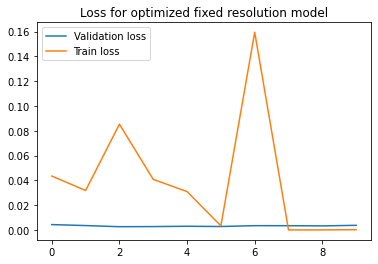

In [25]:
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Train loss")
plt.title("Loss for optimized fixed resolution model")
plt.legend()

In [26]:
#final run over test set
loss, acc = test(testloader, model, loss_fn)

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.003374 



In [29]:
loss

0.003373999096834328

In [30]:
acc

97.69